# OPTICS: density based clustering model

In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import pandas as pd

## Embedding: Word2Vec

### Data: mention1

In [4]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_mention1.jsonl", orient = 'index')

In [5]:
# "transform embedding"
from ast import literal_eval
emb['embedding1'] = emb['embedding1'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embedding1'].values)
matrix.shape

(7298, 300)

In [6]:
X = matrix.copy()

In [7]:
X.shape

(7298, 300)

## Dimensionality reduction: PCA

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [8]:
# Reduce the dimensionality of the embeddings (optional)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X)
X = reduced_embeddings.copy()

In [9]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [10]:
optimal_num_clusters

2

### elbow method

In [11]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

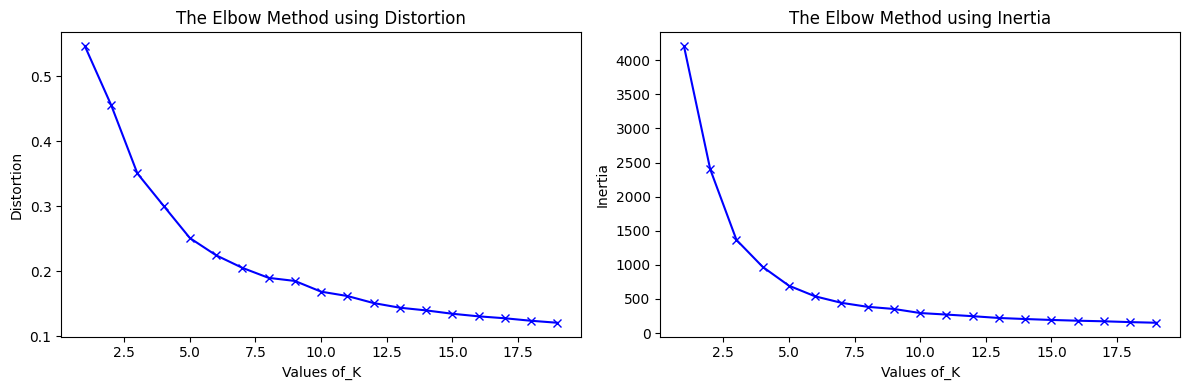

In [12]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [13]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 7, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['random_0'] = final_cluster_labels  

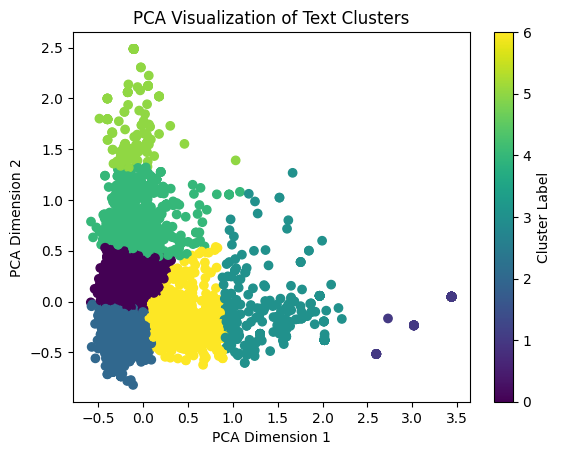

In [14]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('PCA Dimension 1')
ax1.set_ylabel('PCA Dimension 2')
ax1.set_title('PCA Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [15]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 1\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 1"

Silhouette Coefficient: 0.4510050252838333
Calinski-Harabasz Index: 10320.299474217094
Davies-Bouldin Index: 0.6653256569653206


## Dimensionality reduction: UMAP

In [50]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [51]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [52]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [53]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

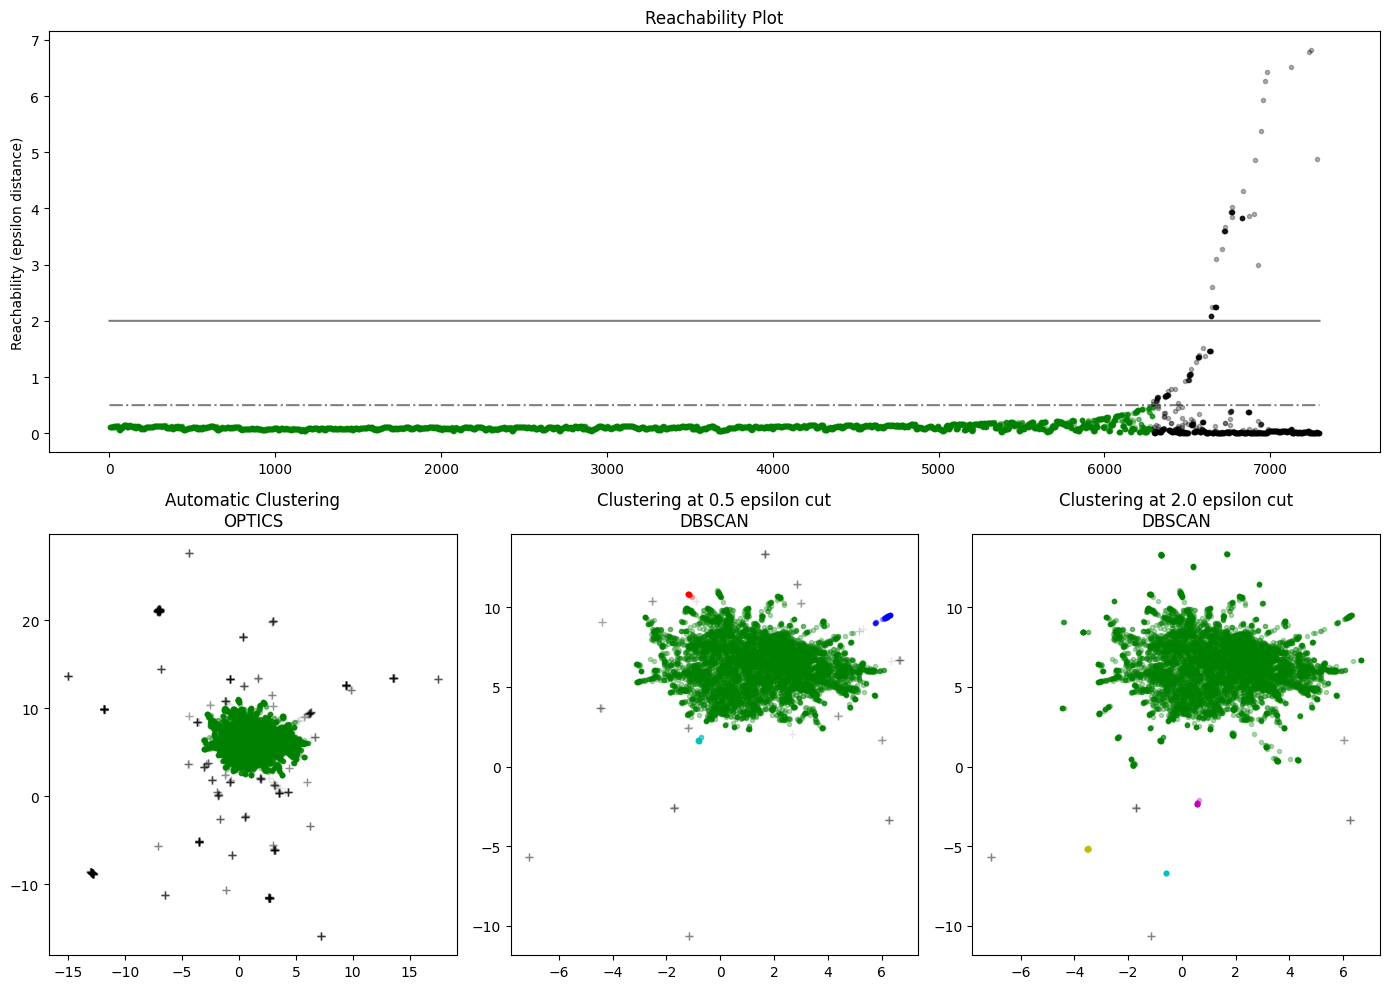

In [54]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

### Result: word2Vec embedding with OPTICS
: clustering seems pretty bad because there is no cluster that can be observed. try different dataset as well.

## Embedding: GloVe

### Data: mention1

In [16]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_glove_mention1.jsonl", orient = 'index')

In [17]:
# "transform embedding"
emb['embedding1'] = emb['embedding1'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embedding1'].values)
matrix.shape

(7298, 300)

In [18]:
X = matrix.copy()

In [19]:
X.shape

(7298, 300)

## Dimensionality reduction: PCA

In [20]:
# Reduce the dimensionality of the embeddings (optional)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(X)
X = reduced_embeddings.copy()

In [21]:
# Step 3: Use silhouette score to find optimal number of clusters
silhouette_scores = []
for num_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

The last line derives from the fact that silhouette score is calculated from the num_cluster 2, so therefore if retrieving index of the lists, the first element's index is 0 but it indicates the value of num_cluster 2, therefore +2 would make it easier to retrieve the value. 


In [22]:
optimal_num_clusters

3

### elbow method

In [23]:
# Use Elbow-analysis as well to find optimal number of clusters
# Elbow analysis
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 20)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

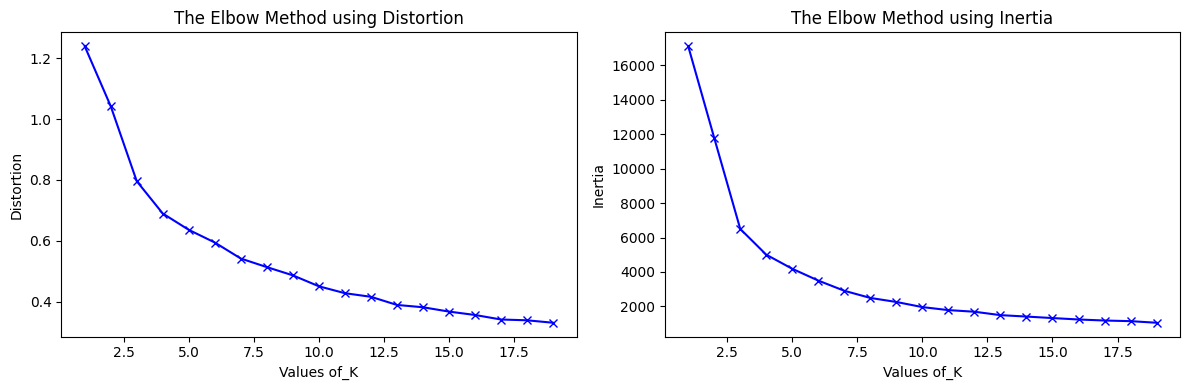

In [24]:
# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Adjust figsize as needed

# Plot the first plot on ax1
ax1.plot(K, distortions, 'bx-')
ax1.set_xlabel('Values of_K')
ax1.set_ylabel('Distortion')
ax1.set_title('The Elbow Method using Distortion')


# Plot the second plot on ax2
ax2.plot(K, inertias, 'bx-')
ax2.set_xlabel('Values of_K')
ax2.set_ylabel('Inertia')
ax2.set_title('The Elbow Method using Inertia')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

## KMeans clustering

In [25]:
# Step 4: Perform final clustering
final_kmeans = KMeans(n_clusters = 7, random_state=0)
final_cluster_labels = final_kmeans.fit_predict(X)

# Save the result of clustering with random state 0 as a dataframe column
emb['random_0'] = final_cluster_labels  

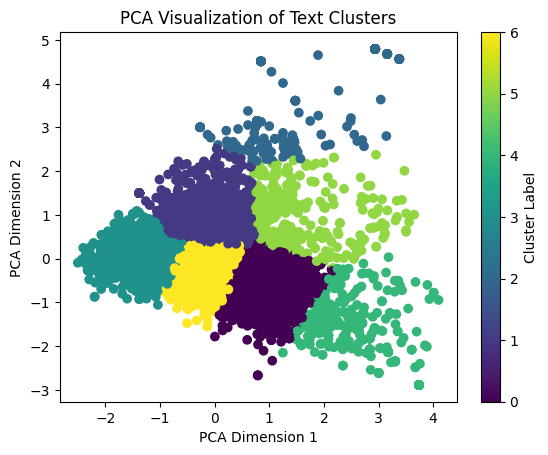

In [26]:
# Visualize clustering depending on different random states.
figures = [] # list to hold different figures. 

fig1, ax1 = plt.subplots()
scatter = ax1.scatter(X[:, 0], X[:, 1], c=final_cluster_labels, cmap='viridis')
ax1.set_xlabel('PCA Dimension 1')
ax1.set_ylabel('PCA Dimension 2')
ax1.set_title('PCA Visualization of Text Clusters')

colorbar = plt.colorbar(scatter, ax=ax1)
colorbar.set_label('Cluster Label')

figures.append(fig1)

In [27]:
# Cluster labels obtained from clustering algorithm

final_cluster_labels # cluster_labels_from_bert
X # contextualized tokens of the input texts.

# Specify the question that is addressed. 
print("\n\"Question 1\"\n")

# Calculate Silhouette Coefficient
silhouette = silhouette_score(X, final_cluster_labels)
print(f"Silhouette Coefficient: {silhouette}")

# Calculate Calinski-Harabasz Index
calinski = calinski_harabasz_score(X, final_cluster_labels)
print(f"Calinski-Harabasz Index: {calinski}")

# Calculate Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, final_cluster_labels)
print(f"Davies-Bouldin Index: {davies_bouldin}")


"Question 1"

Silhouette Coefficient: 0.3655802107006508
Calinski-Harabasz Index: 5931.69488737924
Davies-Bouldin Index: 0.8181053148322233


## Dimensionality reduction: UMAP

In [60]:
# Step 1: Normalize the data
normalized_embeddings = StandardScaler().fit_transform(X)

In [61]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [62]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

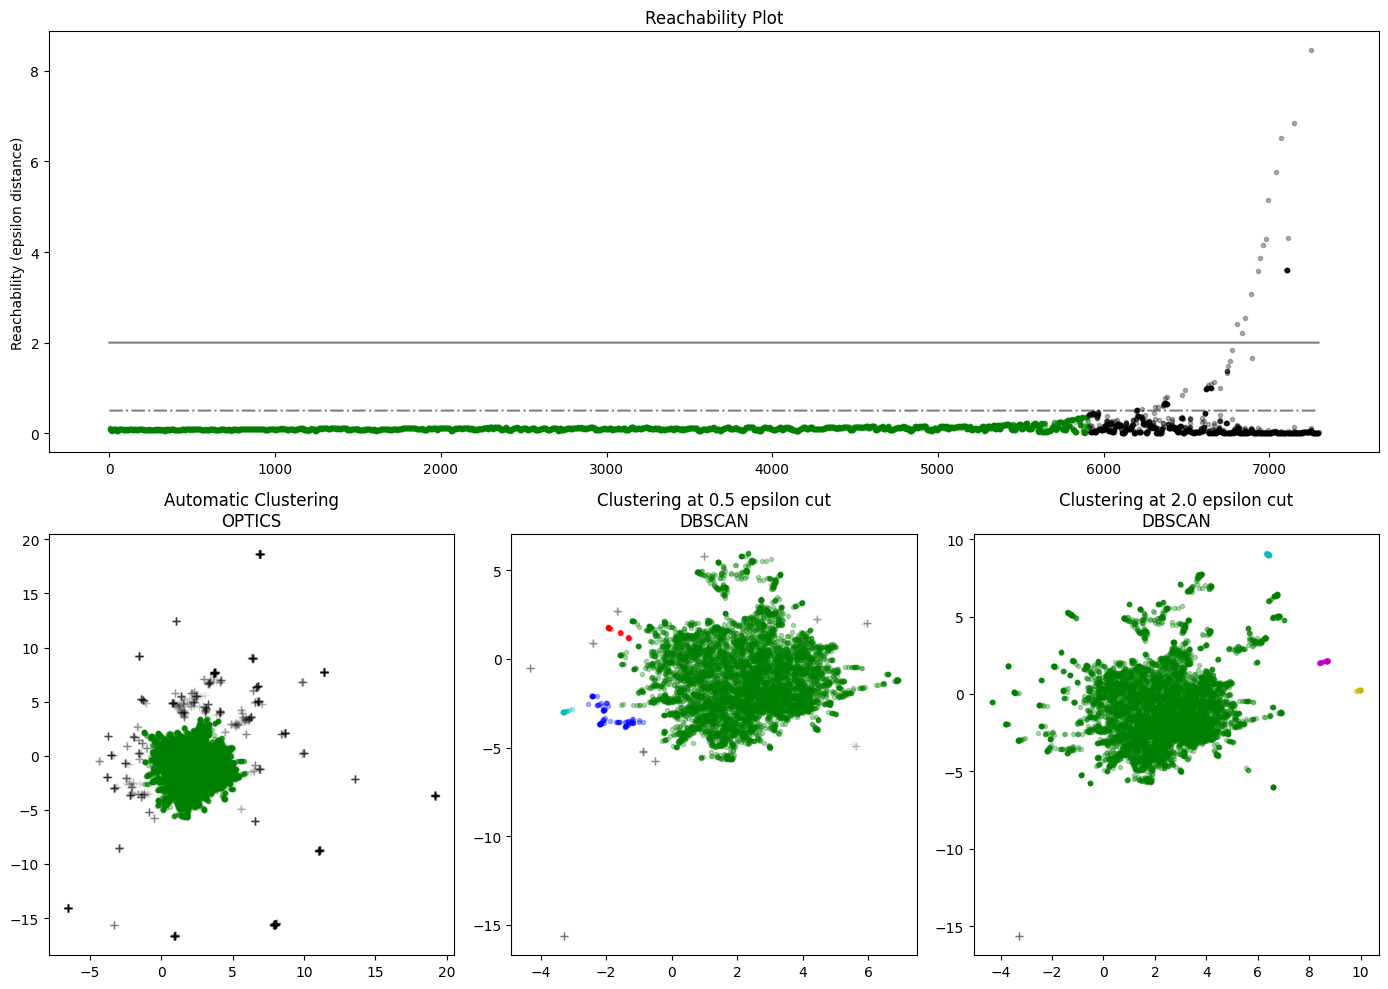

In [65]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

### result: glove embedding is also not successful. Is it has to do with the min_samples parameters? 

## Embedding: distilbert

### Data: concatenated

In [72]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_distilbert_mentions.jsonl", orient = 'index')

In [73]:
# "transform embedding"
from ast import literal_eval
emb['embeddings'] = emb['embeddings'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embeddings'].values)
matrix.shape

(7298, 768)

In [74]:
X = matrix.copy()

In [75]:
X.shape

(7298, 768)

## Dimensionality reduction: UMAP

In [7]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/home/kim/venvs/my_environment/lib/python3.9/site-packages/umap/dist

In [76]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [77]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [84]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

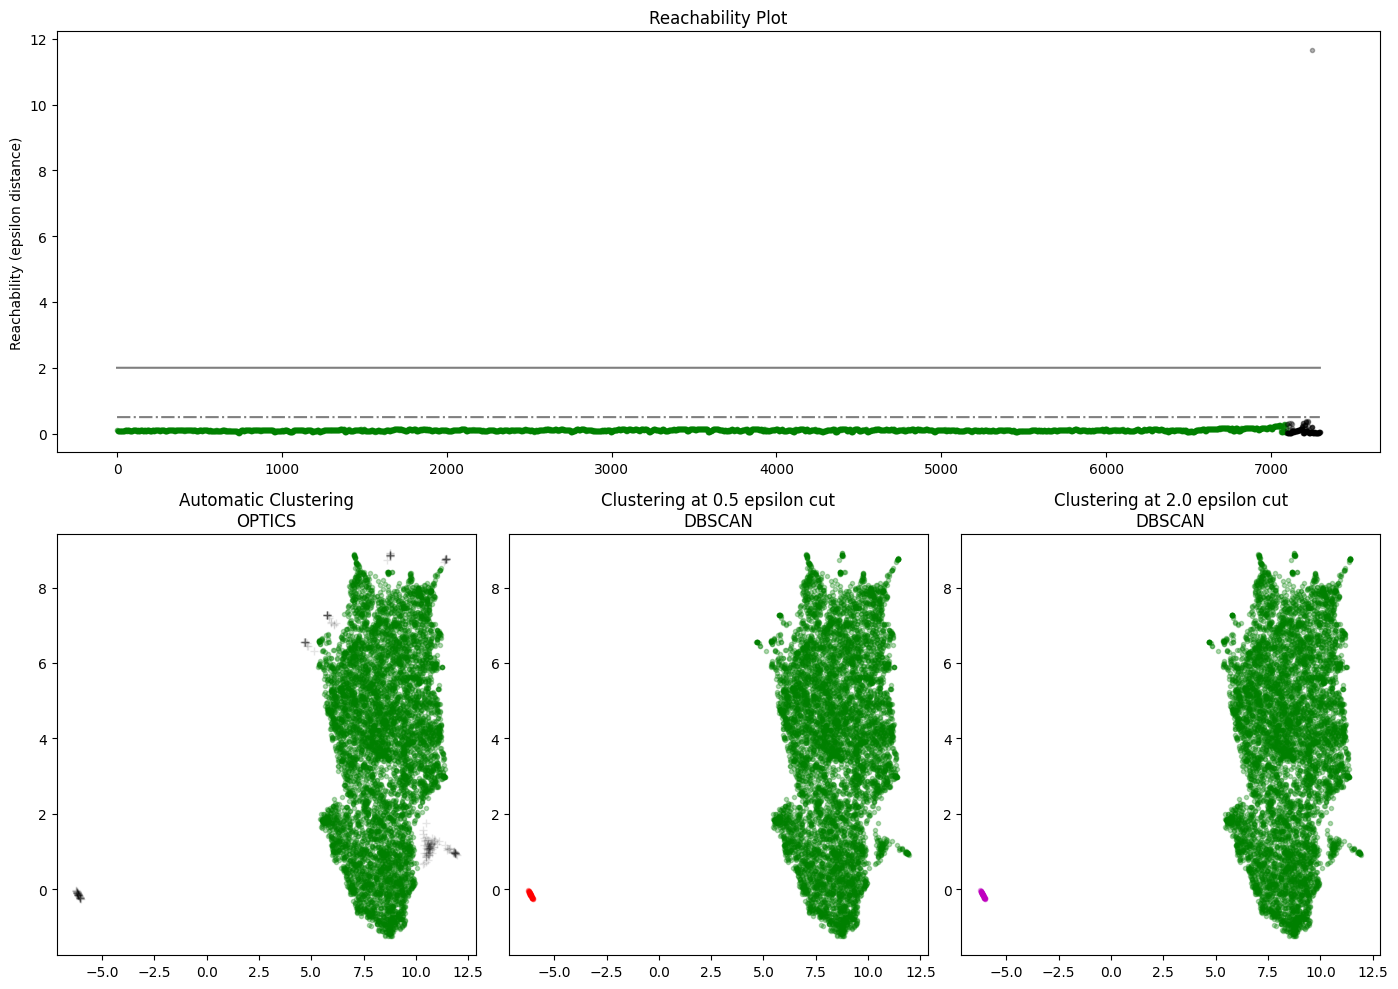

In [85]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: word2vec

### Data: concatenated

In [12]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_word2vec_mentions.jsonl", orient = 'index')

In [13]:
# "transform embedding"
from ast import literal_eval
emb['embeddings'] = emb['embeddings'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embeddings'].values)
matrix.shape

(7298, 300)

In [14]:
X = matrix.copy()

In [15]:
X.shape

(7298, 300)

## Dimensionality reduction: UMAP

In [16]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [17]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [18]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [19]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

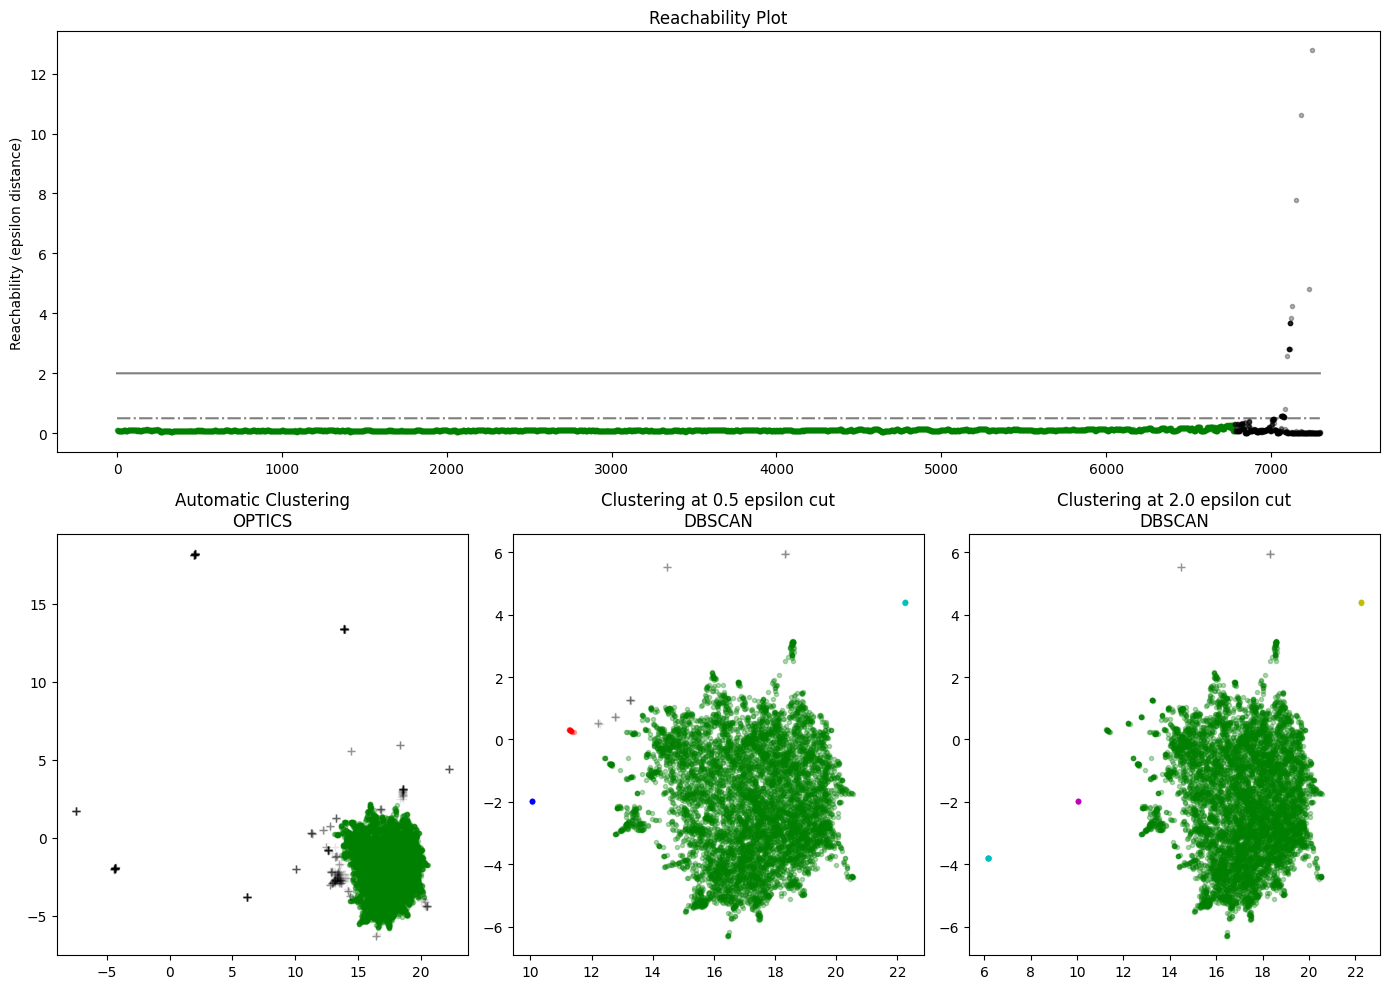

In [20]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: GloVe

### Data: concatenated

In [21]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_glove_mentions.jsonl", orient = 'index')

In [22]:
# "transform embedding"
from ast import literal_eval
emb['embeddings'] = emb['embeddings'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['embeddings'].values)
matrix.shape

(7298, 300)

In [23]:
X = matrix.copy()

In [24]:
X.shape

(7298, 300)

## Dimensionality reduction: UMAP

In [25]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [26]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [27]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [28]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

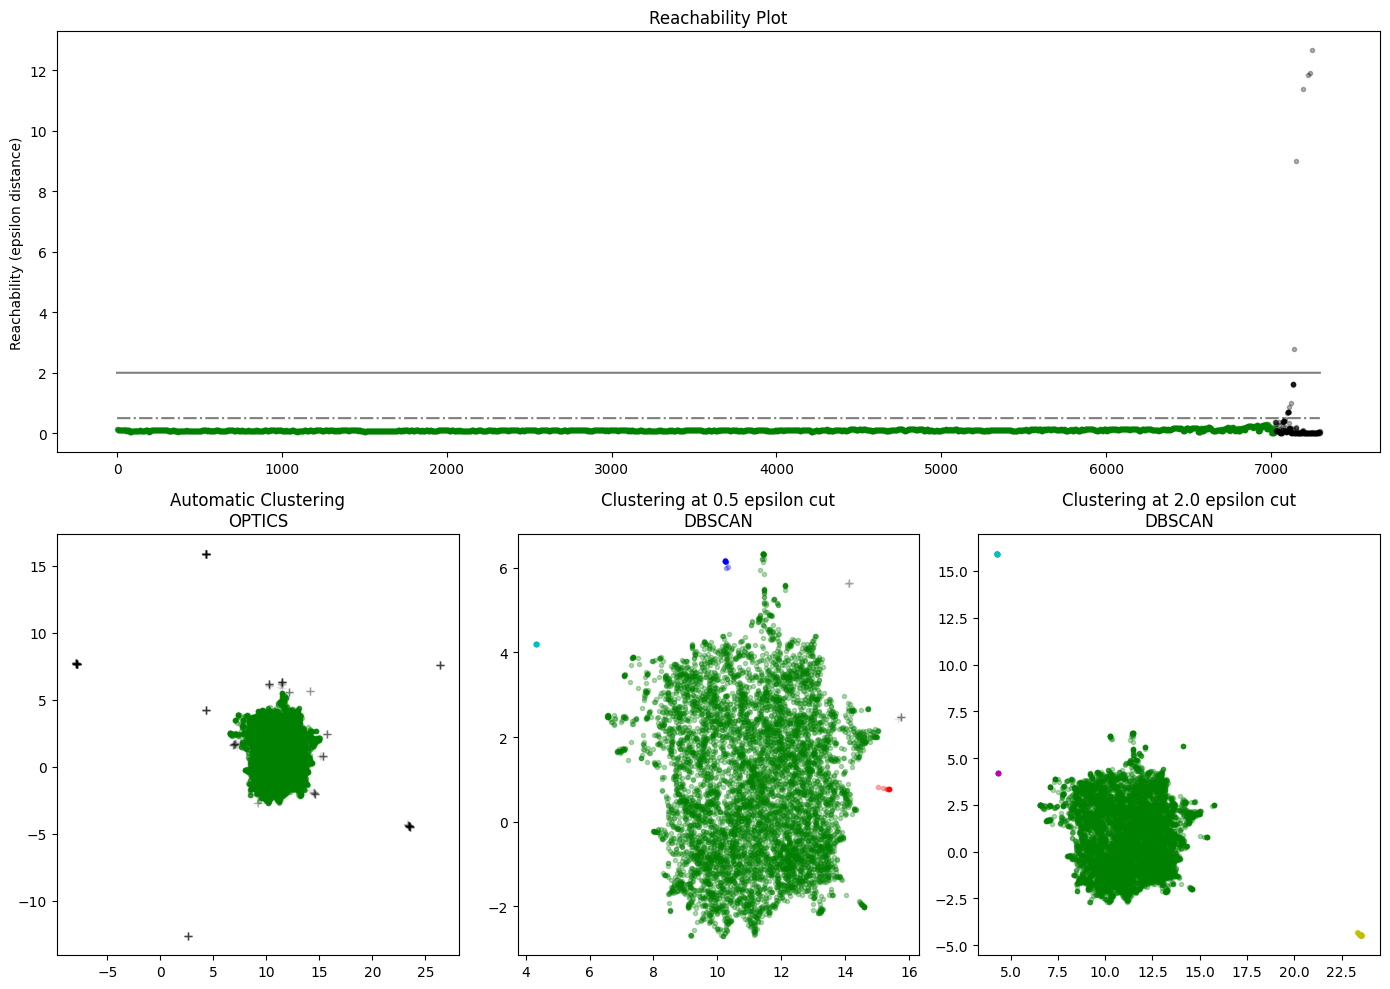

In [29]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: distilbert

### Data: flat

In [30]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_distilbert_mentions_flat.jsonl", orient = 'index')

In [32]:
# "transform embedding"
from ast import literal_eval
emb['mentions_flat'] = emb['mentions_flat'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['mentions_flat'].values)
matrix.shape

(7298, 2304)

In [33]:
X = matrix.copy()

In [34]:
X.shape

(7298, 2304)

## Dimensionality reduction: UMAP

In [35]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [36]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [37]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [38]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

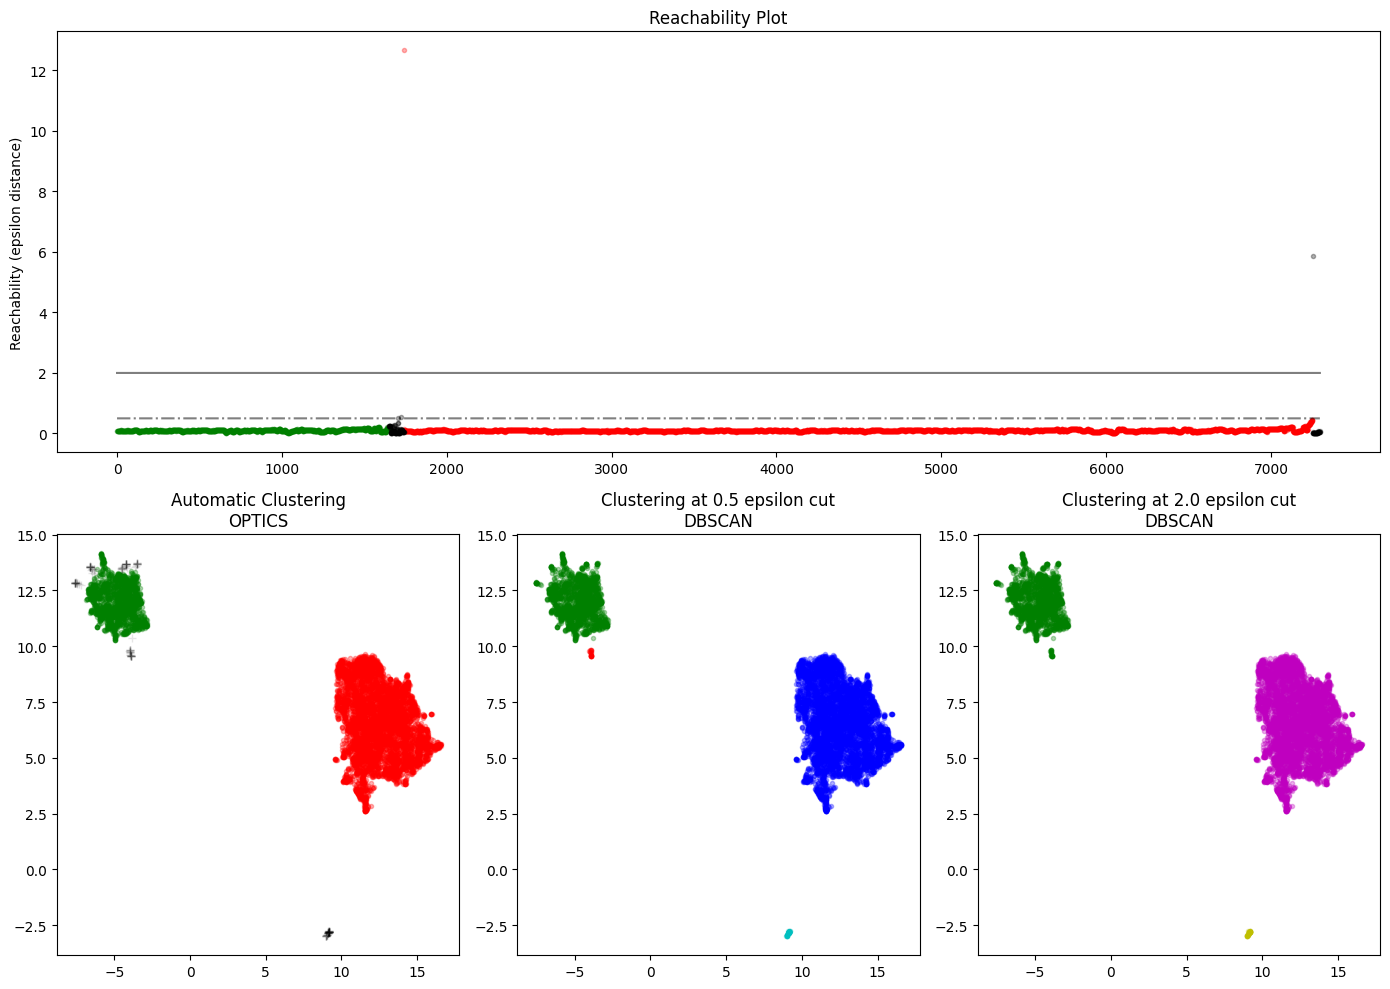

In [39]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: word2vec

### Data: flat

In [40]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_word2vec_mentions_flat.jsonl", orient = 'index')

In [41]:
# "transform embedding"
from ast import literal_eval
emb['mentions_flat'] = emb['mentions_flat'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['mentions_flat'].values)
matrix.shape

(7298, 900)

In [42]:
X = matrix.copy()

In [43]:
X.shape

(7298, 900)

## Dimensionality reduction: UMAP

In [44]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [45]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [46]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [47]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

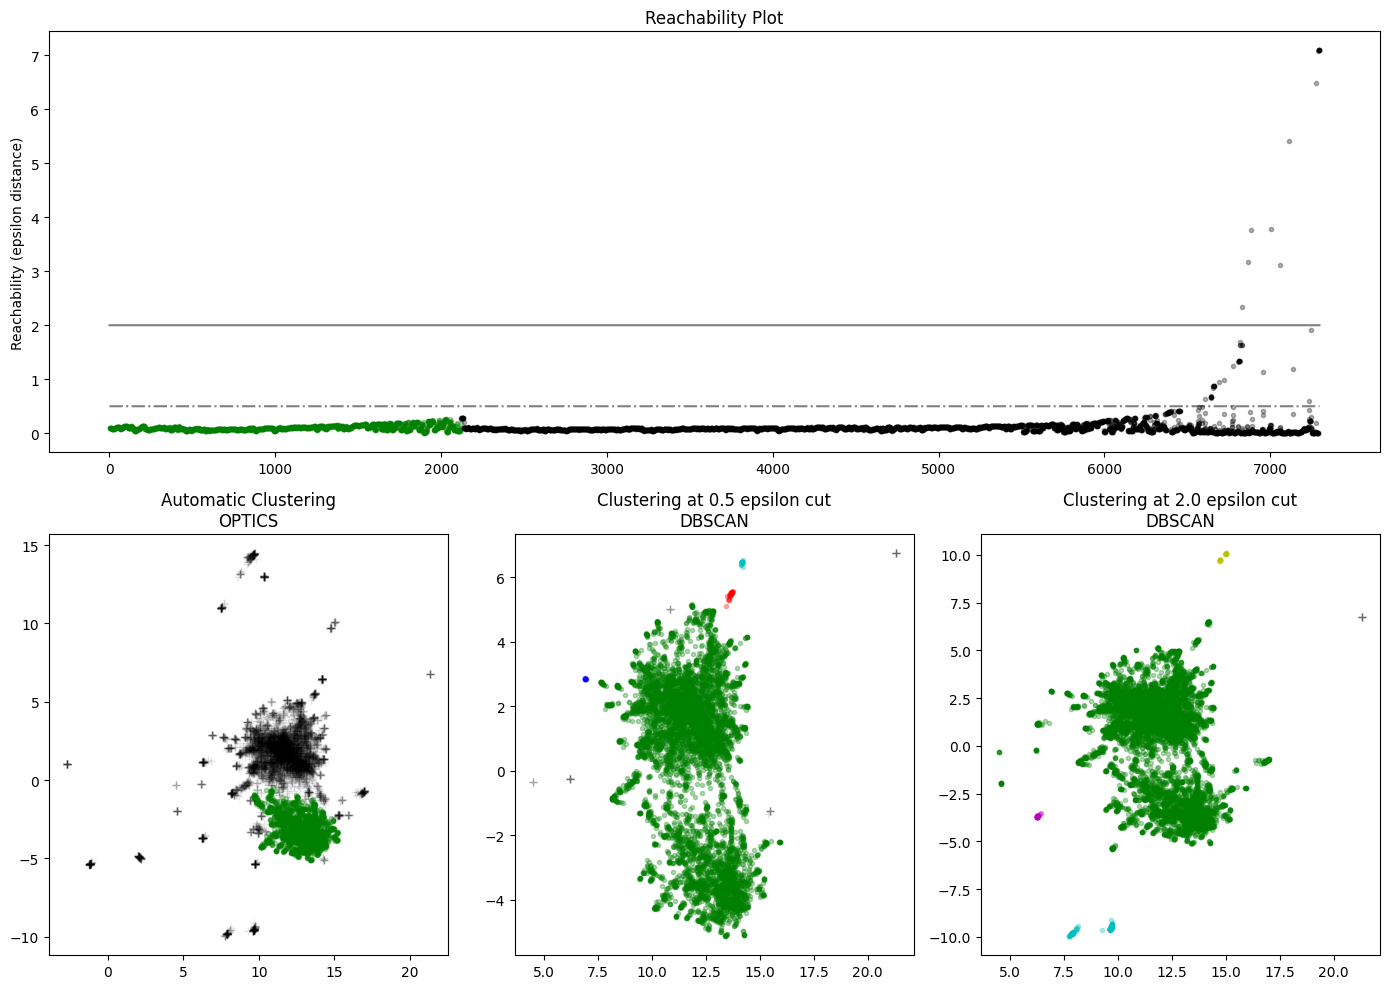

In [48]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: glove

### Data: flat

In [49]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_glove_mentions_flat.jsonl", orient = 'index')

In [50]:
# "transform embedding"
from ast import literal_eval
emb['mentions_flat'] = emb['mentions_flat'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['mentions_flat'].values)
matrix.shape

(7298, 900)

In [51]:
X = matrix.copy()

In [52]:
X.shape

(7298, 900)

## Dimensionality reduction: UMAP

In [53]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [54]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [55]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [62]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.01, min_samples=10)

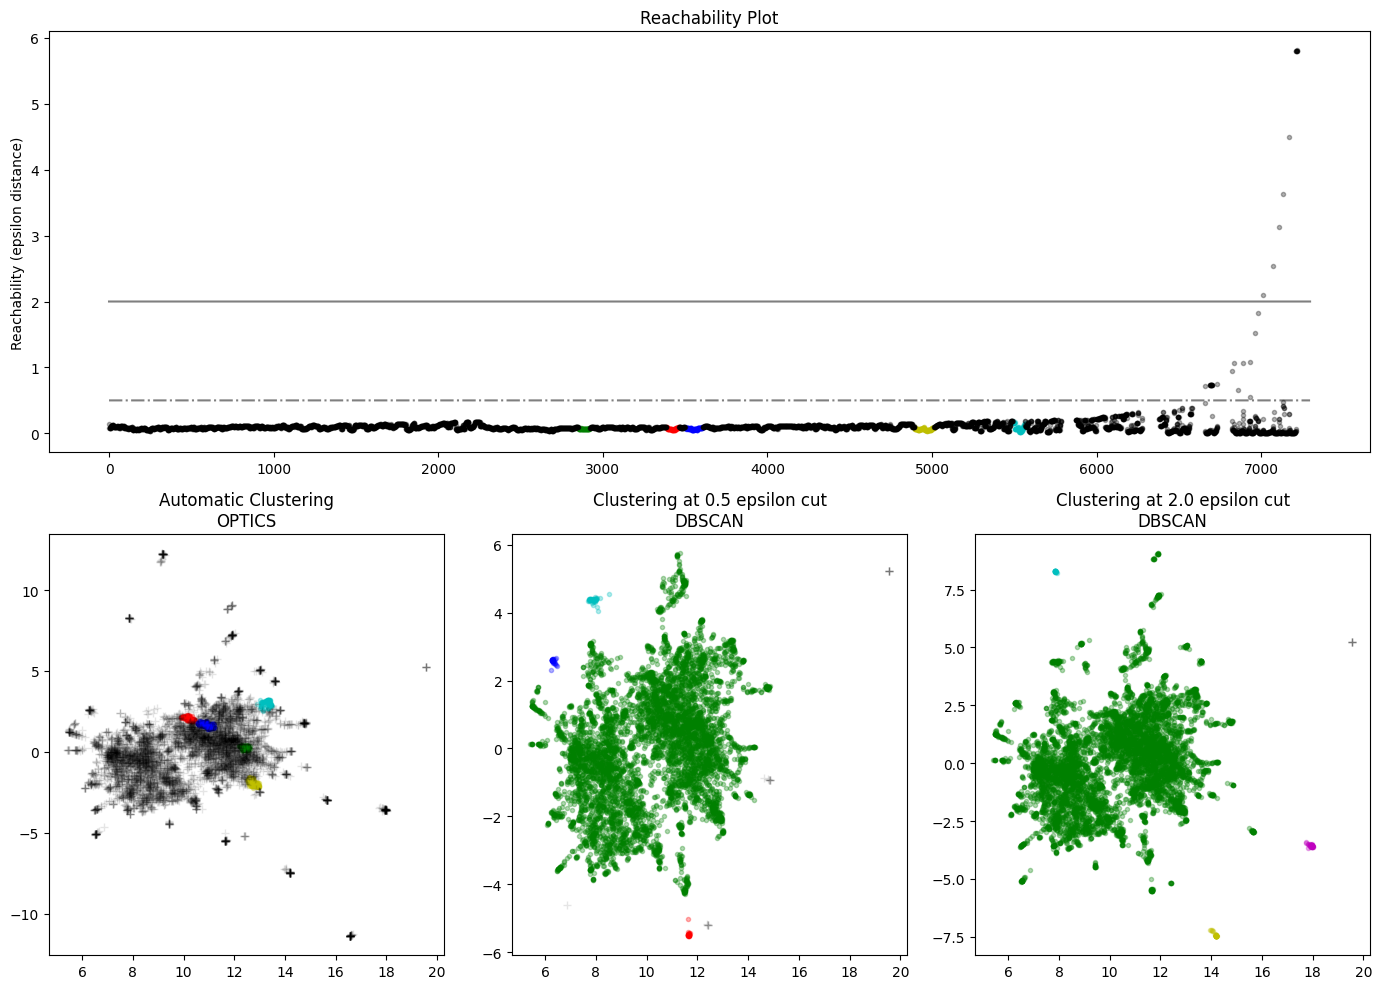

In [63]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: distilbert

### Data: mean

In [86]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_distilbert_mentions_mean.jsonl", orient = 'index')

In [87]:
# "transform embedding"
from ast import literal_eval
emb['mentions_mean'] = emb['mentions_mean'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['mentions_mean'].values)
matrix.shape

(7298, 768)

In [88]:
X = matrix.copy()

In [89]:
X.shape

(7298, 768)

## Dimensionality reduction: UMAP

In [90]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [91]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [92]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [93]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

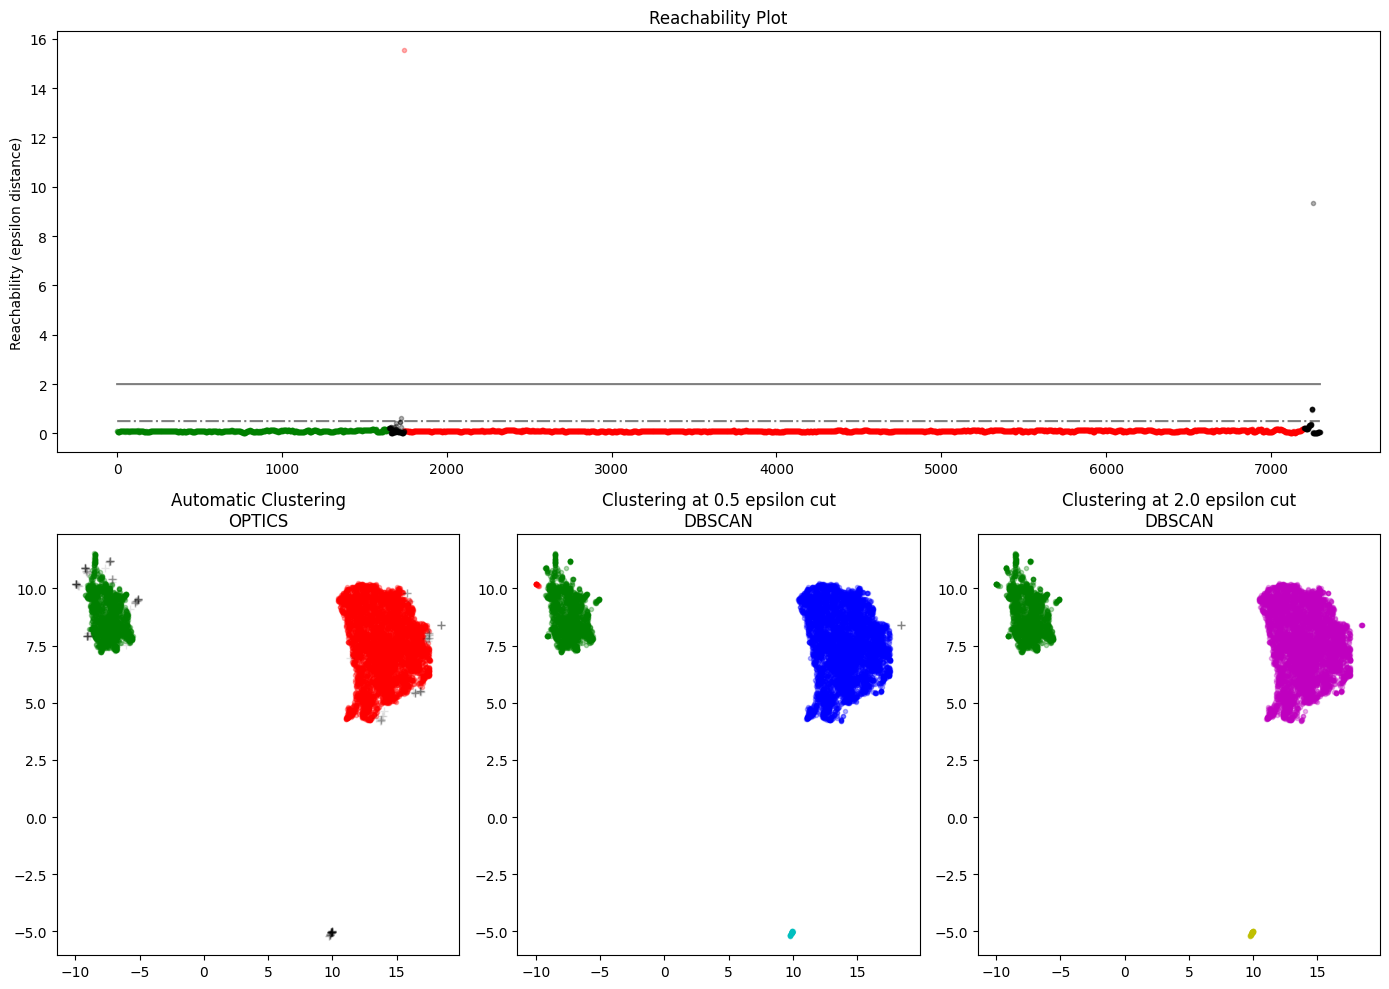

In [94]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: word2vec

### Data: mean

In [95]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_word2vec_mentions_mean.jsonl", orient = 'index')

In [96]:
# "transform embedding"
from ast import literal_eval
emb['mentions_mean'] = emb['mentions_mean'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['mentions_mean'].values)
matrix.shape

(7298, 300)

In [97]:
X = matrix.copy()

In [98]:
X.shape

(7298, 300)

## Dimensionality reduction: UMAP

In [99]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [100]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [101]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [102]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

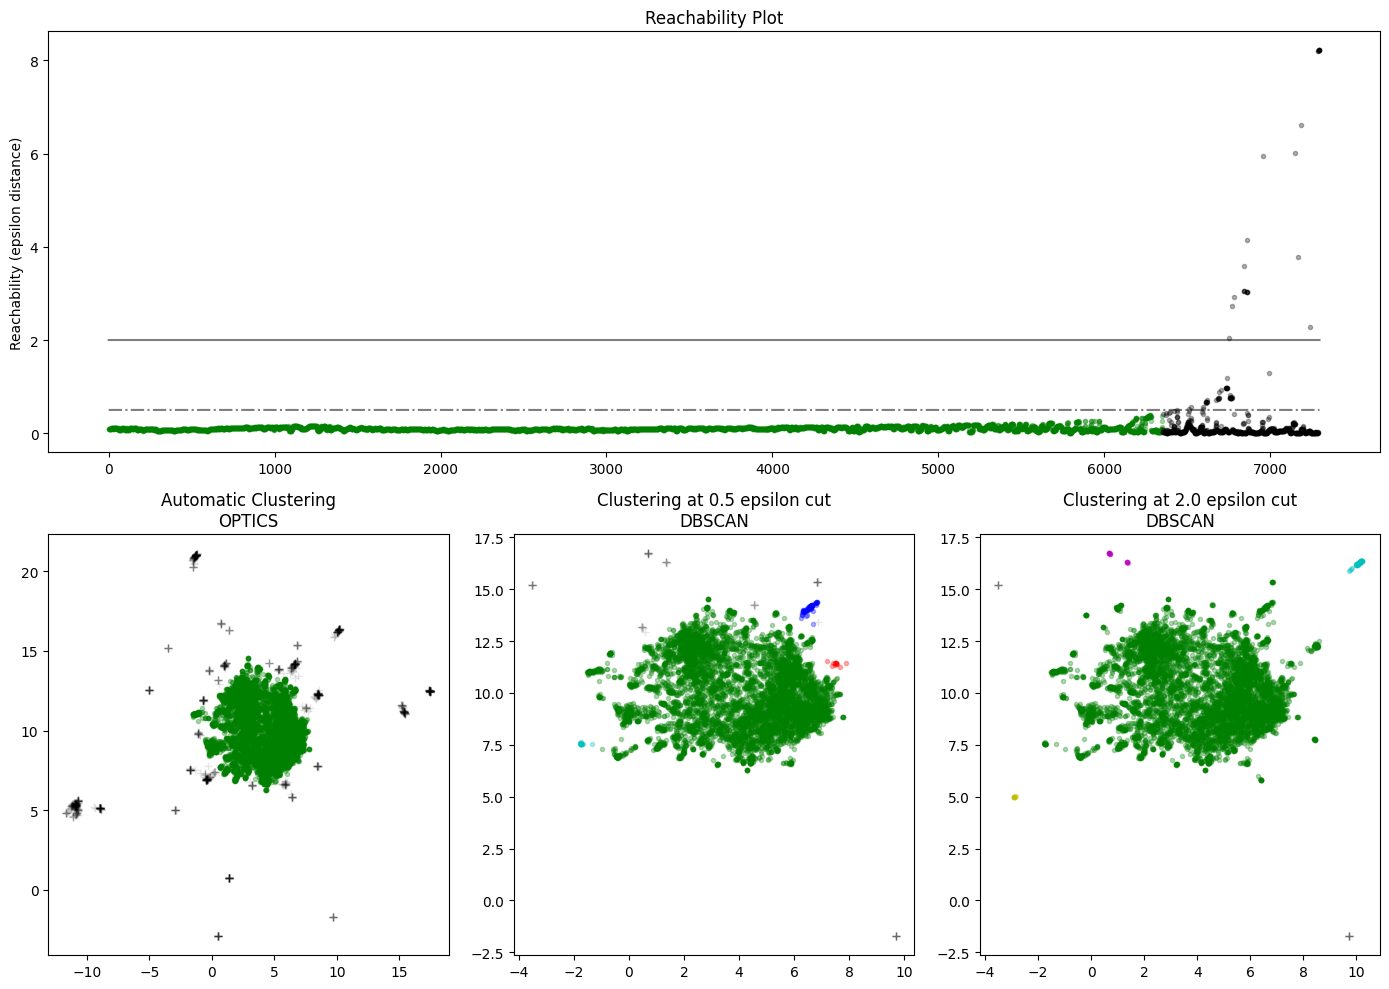

In [103]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

## Embedding: glove

### Data: mean

In [104]:
# Read the embedding file. Check generating procedure from the 'generate_embedding.ipynb' file. 
emb = pd.read_json("~/thesis/embeddings/response_glove_mentions_mean.jsonl", orient = 'index')

In [105]:
# "transform embedding"
from ast import literal_eval
emb['mentions_mean'] = emb['mentions_mean'].apply(np.array)  # convert list to numpy array
matrix = np.vstack(emb['mentions_mean'].values)
matrix.shape

(7298, 300)

In [106]:
X = matrix.copy()

In [107]:
X.shape

(7298, 300)

## Dimensionality reduction: UMAP

In [108]:
from umap import UMAP
from sklearn import metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist

In [109]:
# Step 1: Normalize the data
from sklearn.preprocessing import StandardScaler
normalized_embeddings = StandardScaler().fit_transform(X)

In [110]:
# Step 2: Apply UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=10, min_dist=0.1, n_components=2, random_state=0)
umap_embeddings = umap_model.fit_transform(normalized_embeddings)
X = umap_embeddings.copy()

In [111]:
# Set the randomness
np.random.seed(0)

# Compute OPTICS clustering
clustering = OPTICS(min_samples=10, xi=0.05, min_cluster_size=0.05)
clustering.fit(X)

OPTICS(min_cluster_size=0.05, min_samples=10)

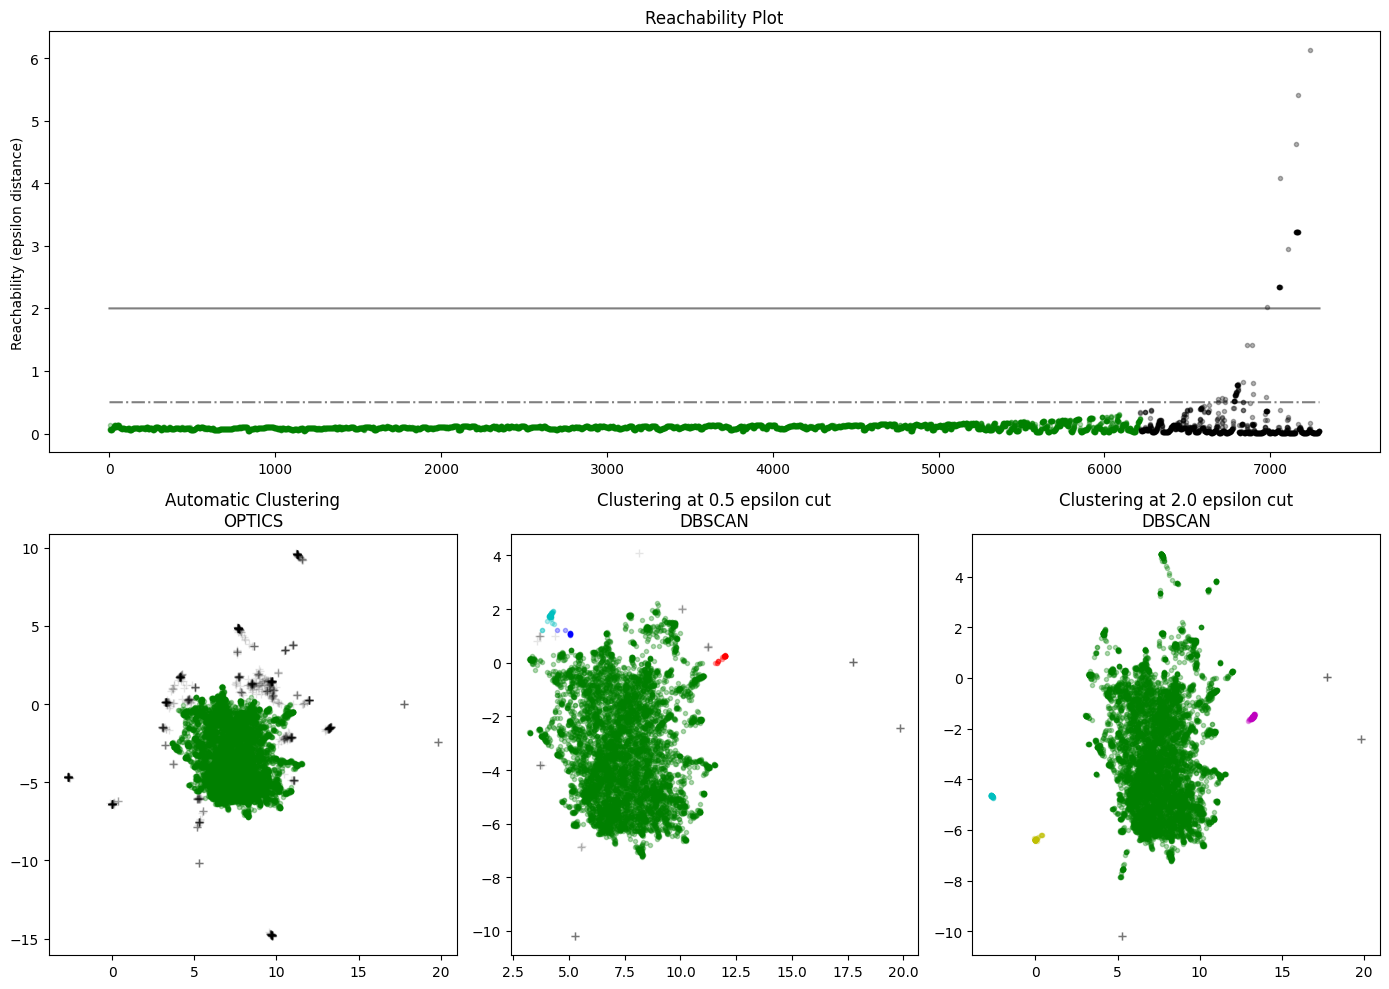

In [112]:
labels_050 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clustering.reachability_,
    core_distances=clustering.core_distances_,
    ordering=clustering.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clustering.reachability_[clustering.ordering_]
labels = clustering.labels_[clustering.ordering_]


# Create subplots
plt.figure(figsize=(14, 10))
G = gridspec.GridSpec(2, 3)

# Reachability plot
ax1 = plt.subplot(G[0, :])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# convert list X to array X for the visualization
X = np.array(X) 

# Automatic Clustering with OPTICS
ax2 = plt.subplot(G[1, 0])
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[ clustering.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clustering.labels_ == -1, 0], X[clustering.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at eps = 0.5
ax3 = plt.subplot(G[1, 1])
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at eps = 2
ax4 = plt.subplot(G[1, 2])
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()